In [1]:
import toml
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from os.path import join
from scipy import stats, signal
from rl_analysis.plotting import add_legend, save_factory
from rl_analysis.plotting import setup_plotting_env, clean_ticks, COLORS, fg

In [2]:
def filter_signal(v):
    sos = signal.butter(2, 3, output="sos", fs=30.)
    f = signal.sosfiltfilt(sos, v)
    return f

In [3]:
ts_scale = 1.25e-4

In [4]:
with open("../analysis_configuration.toml", "r") as f:
    config = toml.load(f)

In [5]:
data = joblib.load(join(config['intermediate_results']['dlight'], 'open_loop_dlight_data.p.z'))

## Find peaks, compare stim trials to spontaneous dLight

In [6]:
setup_plotting_env()
saver = save_factory(join(config['figures']['store_dir'], 'fig-03'), tight_layout=False)

In [7]:
pctiles = [stats.percentileofscore(np.concatenate(data['spont_peaks']), x) for x in np.concatenate(data['stim_peaks'])]

In [8]:
_min = np.min(np.concatenate(data['stim_peaks'] + data['spont_peaks']))

In [9]:
# fraction of maximum spontaneous peak
max_frac = (np.concatenate(data["stim_peaks"]) - _min) / np.percentile(
    np.concatenate(data["spont_peaks"]) - _min, 99
)

In [10]:
len(max_frac)

842

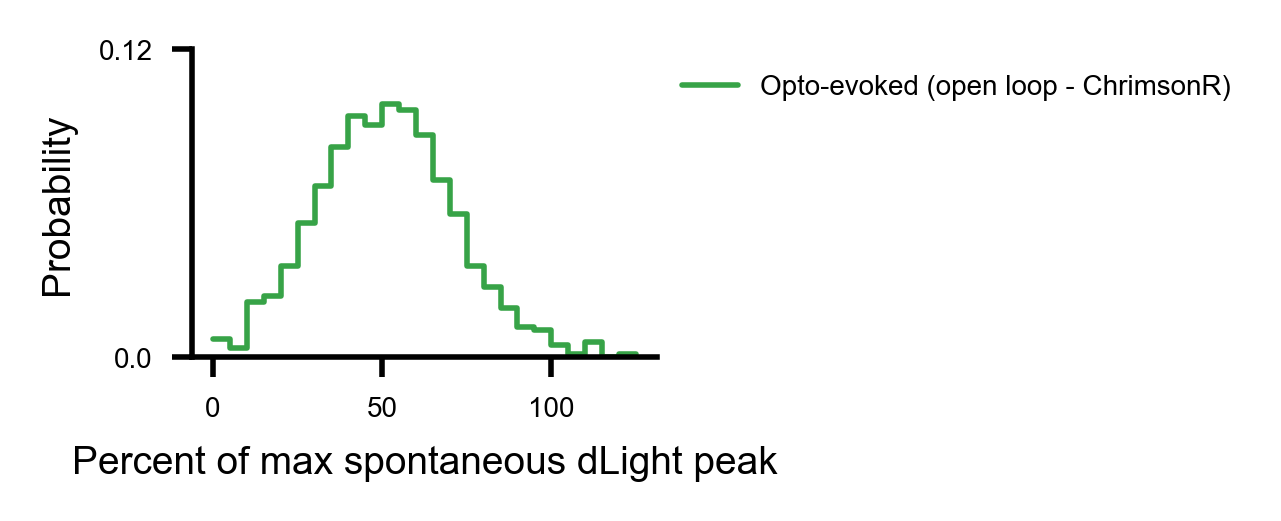

In [11]:
fig = fg(1.5, 1)
fig.dpi = 200
ax = sns.histplot(
    max_frac * 100,
    color=COLORS["green"],
    element="step",
    linewidth=1,
    binwidth=5,
    fill=False,
    stat="probability",
    label="Opto-evoked (open loop - ChrimsonR)",
)
sns.despine()
ax.set(ylim=(0, 0.12), xticks=[0, 50, 100])
clean_ticks(ax, axis="y", zero_symmetry=False, precision=2)
add_legend(ax)
plt.xlabel("Percent of max spontaneous dLight peak")
saver(fig, "open-loop-fraction-of-spontaneous-histplot");

In [12]:
np.concatenate(data['stim_peaks']).mean()

2.189504161456485

In [13]:
np.concatenate(data['stim_peaks']).std()

0.8555294954280022

In [14]:
np.concatenate(data['spont_peaks']).mean()

2.235521594620924

In [15]:
np.concatenate(data['spont_peaks']).std()

0.6261615064670043

In [16]:
np.concatenate(data['spont_thresholded_peaks']).mean()

2.235521594620924

In [17]:
np.concatenate(data['spont_thresholded_peaks']).std()

0.6261615064670043

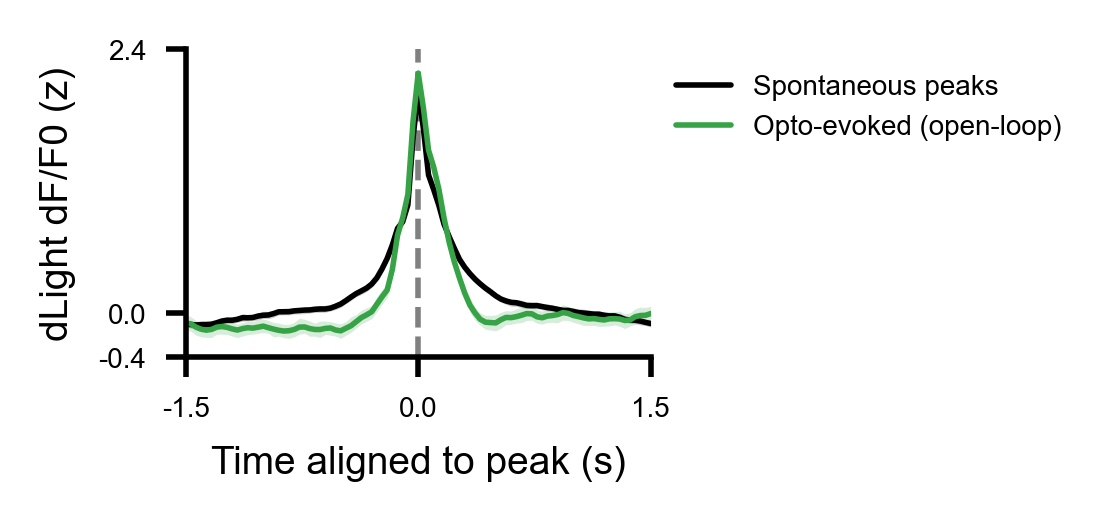

In [18]:
fig = fg(1.5, 1)
fig.dpi = 200

ax = sns.lineplot(
    data=pd.concat(data["spont_thresholded_waveforms"], ignore_index=True),
    x="time",
    y="dlight",
    color="k",
    linewidth=1,
    label="Spontaneous peaks",
    err_kws=dict(linewidth=0),
    n_boot=200,
)

sns.lineplot(
    data=pd.concat(data["stim_waveforms"], ignore_index=True),
    x="time",
    y="dlight",
    label="Opto-evoked (open-loop)",
    color=COLORS['green'],
    linewidth=1,
    err_kws=dict(linewidth=0),
    n_boot=200,
)

sns.despine()

plt.xlim(-1.5, 1.5)
plt.ylabel("dLight dF/F0 (z)")
plt.xlabel("Time aligned to peak (s)")

add_legend(ax)
clean_ticks(ax, axis="y", zero_symmetry=False, precision=1)
clean_ticks(ax, axis="x", zero_symmetry=False, precision=1)

plt.axvline(0, color="gray", linestyle="--", linewidth=1, zorder=-5)
saver(fig, "dlight-vs-spontaneous-open-loop-waveforms");